In [1]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from sklearn.manifold import TSNE
import plotly_express as px

In [2]:
OHCO = ['company_id', 'link_num', 'sent_num', 'token_num']

In [3]:
TOKENS = pd.read_csv('data/TOKENS.csv').set_index(OHCO)
TOKENS

pos_tuple  pos  \
company_id link_num sent_num token_num                                 
1          0        0        0          ('Manufacturer', 'NNP')  NNP   
                             3              ('Hardware', 'NNP')  NNP   
                             4                ('Custom', 'NNP')  NNP   
                             5                 ('Metal', 'NNP')  NNP   
                             6              ('Crafters', 'NNP')  NNP   
...                                                         ...  ...   
1222       2        4        0                ('Success', 'NN')   NN   
                    5        1                ('message', 'NN')   NN   
                    6        3             ('PentaCast', 'NNP')  NNP   
                             4                   ('Inc', 'NNP')  NNP   
                    7        0                    ('Tel', 'NN')   NN   

                                           token_str      term_str  
company_id link_num sent_num token_num                              
1          0        0        0          Manufacturer  manufacturer  
                             3              Hardware      hardware  
                             4                Custom        custom  
                             5                 Metal         metal  
                             6              Crafters      crafters  
...                                              ...           ...  
1222       2        4        0               Success       success  
                    5        1               message       message  
                    6        3             PentaCast     pentacast  
                             4                   Inc           inc  
                    7        0                   Tel           tel  

[144151 rows x 4 columns]

In [4]:
VOCAB = pd.read_csv('data/VOCAB.csv')
VOCAB

term_str     n         p          i  n_chars max_pos  n_pos  \
0        quality  1369  0.009497   6.718315        7      NN      3   
1       castings  1228  0.008519   6.875126        8     NNS      3   
2       products  1199  0.008318   6.909605        8     NNS      4   
3        casting  1194  0.008283   6.915634        7     NNP      2   
4        contact   944  0.006549   7.254578        7     NNP      2   
...          ...   ...       ...        ...      ...     ...    ...   
12646      beane     1  0.000007  17.137221        5     NNP      1   
12647      lucas     1  0.000007  17.137221        5     NNP      1   
12648  hernandez     1  0.000007  17.137221        9     NNP      1   
12649    enrique     1  0.000007  17.137221        7     NNP      1   
12650   bcormier     1  0.000007  17.137221        8      NN      1   

                            cat_pos      dfidf  mean_tfidf  
0              {'NNS', 'NNP', 'NN'}  22.920115    0.020423  
1            {'NNS', 'NNP', 'NNPS'}  44.741763    0.056828  
2      {'NNS', 'NNP', 'NN', 'NNPS'}  33.358238    0.024701  
3                     {'NNP', 'NN'}  45.154499    0.051122  
4                     {'NNP', 'NN'}  35.475367    0.022390  
...                             ...        ...         ...  
12646                       {'NNP'}   2.477121    0.000550  
12647                       {'NNP'}   2.477121    0.000550  
12648                       {'NNP'}   2.477121    0.000550  
12649                       {'NNP'}   2.477121    0.000550  
12650                        {'NN'}   2.477121    0.000590  

[12651 rows x 10 columns]

In [5]:
BAG = ['company_id', 'link_num']
DOCS = TOKENS[~TOKENS.pos.str.match('NNPS?')]\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
DOCS = [doc for doc in DOCS if len(doc) > 1] # Lose single word docs

## Model 1

In [6]:
# word2vec parameters
w2v_params = dict(
    window = 5,
    vector_size = 200,
    min_count = 50,
    workers = 4
)

In [7]:
model_1 = word2vec.Word2Vec(DOCS, **w2v_params)

In [8]:
coords_1  = pd.DataFrame(
    dict(
        vector = [model_1.wv.get_vector(w) for w in model_1.wv.index_to_key], 
        term_str = model_1.wv.index_to_key
    )).set_index('term_str')

In [9]:
tsne_engine_1 = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_model_1 = tsne_engine_1.fit_transform(coords_1.vector.to_list())

In [10]:
coords_1 ['x'] = tsne_model_1[:,0]
coords_1 ['y'] = tsne_model_1[:,1]

In [11]:
if coords_1 .shape[1] == 3:
    coords_1  = coords_1.merge(VOCAB.reset_index(), on='term_str')
    coords_1  = coords_1.set_index('term_str')

In [12]:
coords_1 

vector          x  \
term_str                                                                    
quality      [0.064423375, -0.11111934, -0.14111212, 0.0530... -12.180115   
products     [0.049373675, -0.06911464, -0.10200264, 0.0166...  -7.790994   
castings     [-0.020082157, -0.2359109, -0.24877127, 0.1007... -14.679938   
customers    [0.069914065, -0.093718275, -0.12506501, 0.042... -10.966983   
parts        [0.009247548, -0.1695984, -0.1942343, 0.090190... -13.927756   
...                                                        ...        ...   
program      [0.037758127, -0.01578404, -0.055056, 0.006332...   5.472015   
protection   [0.011015631, 0.033552665, 0.0084117735, -0.03...  11.168120   
software     [0.03169366, 0.020305868, -0.02759195, -0.0166...   8.935071   
file         [0.016736085, 0.085751854, 0.028928863, -0.047...  12.452018   
maintenance  [0.025280658, -0.022402683, -0.0534546, 0.0012...   3.643089   

                     y  index     n         p          i  n_chars max_pos  \
term_str                                                                    
quality       6.720740      0  1369  0.009497   6.718315        7      NN   
products      3.311322      2  1199  0.008318   6.909605        8     NNS   
castings     11.967529      1  1228  0.008519   6.875126        8     NNS   
customers     5.550053     13   678  0.004703   7.732080        9     NNS   
parts        10.759926     10   743  0.005154   7.600003        5     NNS   
...                ...    ...   ...       ...        ...      ...     ...   
program      -3.929123    399    63  0.000437  11.159941        7      NN   
protection   -8.229728    169   128  0.000888  10.137221       10     NNP   
software     -6.810633    442    59  0.000409  11.254578        8      NN   
file        -10.172930    504    52  0.000361  11.436782        4      NN   
maintenance  -3.075948    307    81  0.000562  10.797371       11      NN   

             n_pos                       cat_pos      dfidf  mean_tfidf  
term_str                                                                 
quality          3          {'NNS', 'NNP', 'NN'}  22.920115    0.020423  
products         4  {'NNS', 'NNP', 'NN', 'NNPS'}  33.358238    0.024701  
castings         3        {'NNS', 'NNP', 'NNPS'}  44.741763    0.056828  
customers        3        {'NNS', 'NNP', 'NNPS'}  38.840662    0.022331  
parts            3        {'NNS', 'NNP', 'NNPS'}  43.013495    0.030131  
...            ...                           ...        ...         ...  
program          2                 {'NNP', 'NN'}  31.634041    0.006879  
protection       2                 {'NNP', 'NN'}  36.681417    0.012354  
software         2                 {'NNP', 'NN'}  34.098831    0.009113  
file             2                 {'NNP', 'NN'}  29.426974    0.006192  
maintenance      2                 {'NNP', 'NN'}  35.002451    0.010582  

[290 rows x 13 columns]

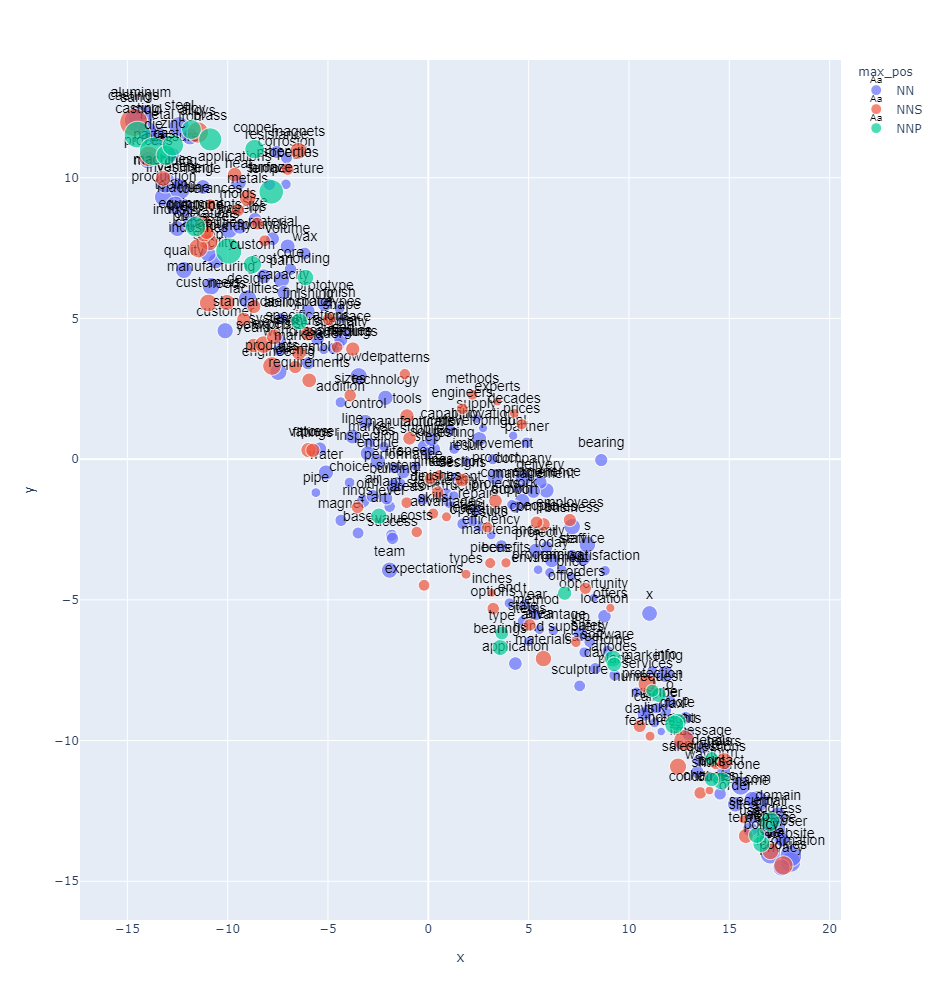

In [13]:
px.scatter(coords_1.reset_index(), 'x', 'y', 
           text='term_str', 
           color='max_pos', 
           hover_name='term_str',          
           size='mean_tfidf',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

In [14]:
def complete_analogy(model, A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(model, positive, negative=None):
    return pd.DataFrame(model.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [15]:
# great
complete_analogy(model_1, 'products', 'product', 'castings', 3)

term       sim
0  process  0.996703
1     cast  0.996023
2    metal  0.995822

In [16]:
# Not Bad.
complete_analogy(model_1, 'metal', 'steel', 'alloy', 3)

term       sim
0   brass  0.990247
1  alloys  0.989958
2  copper  0.988937

In [17]:
# should be castings
complete_analogy(model_1, 'industry', 'industries', 'casting', 3)

term       sim
0   mold  0.998414
1  metal  0.997425
2    die  0.995976

In [18]:
complete_analogy(model_1, 'site', 'com', 'customer', 3)

term       sim
0  customers  0.974743
1      needs  0.970655
2      years  0.969343

In [19]:
get_most_similar(model_1, 'quality')

term       sim
0      customers  0.997352
1       industry  0.995286
2  manufacturing  0.994115
3     industries  0.992123
4     production  0.991677
5           shop  0.991076
6          needs  0.991040
7      equipment  0.990829
8      precision  0.990815
9      processes  0.990356

In [20]:
get_most_similar(model_1, 'magnet')

term       sim
0    advantages  0.997077
1           oil  0.996999
2         rings  0.996955
3     selection  0.996748
4  construction  0.996585
5       options  0.996581
6          base  0.996432
7           air  0.996427
8         costs  0.996347
9         speed  0.996202

In [21]:
get_most_similar(model_1, 'castings')

term       sim
0   casting  0.998382
1  aluminum  0.997276
2      sand  0.995723
3     metal  0.993611
4       die  0.993482
5      mold  0.993191
6     parts  0.991125
7   process  0.990492
8      zinc  0.989305
9      cast  0.987240

In [22]:
get_most_similar(model_1, 'metal')

term       sim
0      mold  0.997858
1      zinc  0.997747
2       die  0.997008
3      cast  0.996947
4   process  0.994860
5   casting  0.994795
6     parts  0.994788
7  aluminum  0.993827
8  castings  0.993611
9      sand  0.992450

In [23]:
get_most_similar(model_1, 'privacy')

term       sim
0       policy  0.998894
1         site  0.998298
2          web  0.996223
3      cookies  0.996053
4         data  0.995968
5        sites  0.995417
6          use  0.994925
7       access  0.994648
8      website  0.993911
9  information  0.991909

In [24]:
get_most_similar(model_1, 'business')

term       sim
0     employees  0.998145
1       service  0.997469
2  satisfaction  0.996608
3             s  0.995409
4        family  0.995206
5        people  0.994696
6         staff  0.994573
7         today  0.994179
8     companies  0.993950
9       project  0.993873

In [25]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

def hca(sims, labels, linkage_method='ward', color_thresh=.3):
    tree = sch.linkage(sims, method=linkage_method)
    fig_height = len(labels) / 3
    plt.figure()
    fig, axes = plt.subplots(figsize=(10, fig_height))
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

def plot_terms_tree(coords, terms_n = 100, color_thresh=1):
    term_filter = coords.index.str.len() > 2
    M = coords[coords.index.str.len() > 2].sort_values('mean_tfidf', ascending=False).vector.head(terms_n)
    IDX = coords.loc[M.index].index #term_str
    hca(M.to_list(), IDX.to_list(), color_thresh=color_thresh)

<Figure size 432x288 with 0 Axes>

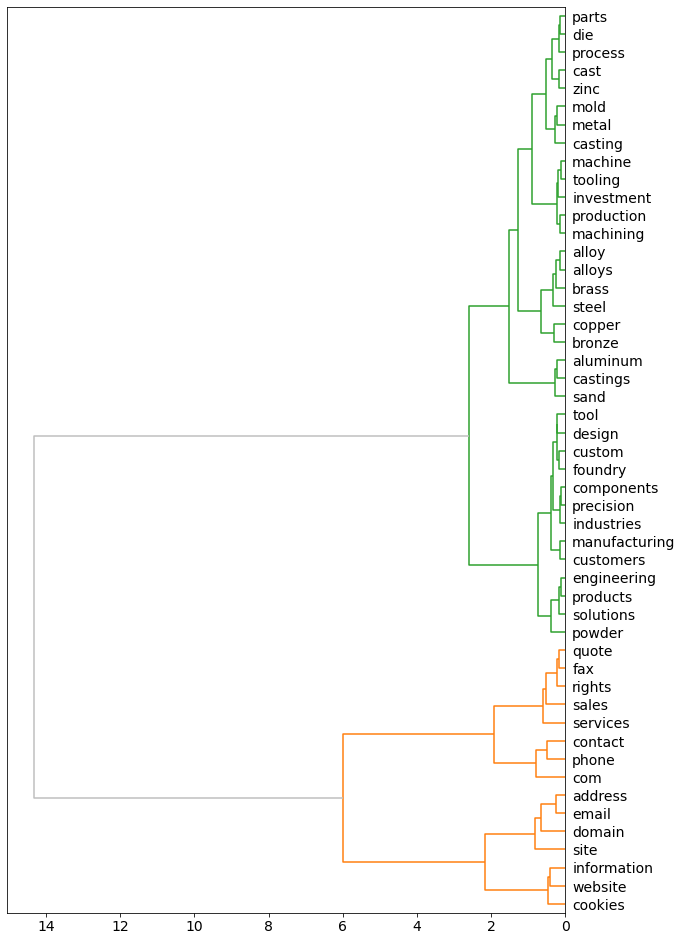

In [26]:
plot_terms_tree(coords_1, color_thresh=9, terms_n=50)

### Model 2

In [27]:
# word2vec parameters
w2v_params = dict(
    window = 5,
    vector_size = 50,
    min_count = 20,
    workers = 4
)

In [28]:
model_2 = word2vec.Word2Vec(DOCS, **w2v_params)

In [29]:
coords_2 = pd.DataFrame(
    dict(
        vector = [model_2.wv.get_vector(w) for w in model_2.wv.index_to_key], 
        term_str = model_2.wv.index_to_key
    )).set_index('term_str')

In [30]:
tsne_engine_2 = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_model_2 = tsne_engine_2.fit_transform(coords_2.vector.to_list())

In [31]:
coords_2['x'] = tsne_model_2[:,0]
coords_2['y'] = tsne_model_2[:,1]

In [32]:
if coords_2.shape[1] == 3:
    coords_2 = coords_2.merge(VOCAB.reset_index(), on='term_str')
    coords_2 = coords_2.set_index('term_str')

In [33]:
coords_2

vector          x  \
term_str                                                                  
quality    [0.11838379, -0.51479673, -0.5177983, 0.500594... -30.736137   
products   [0.08134762, -0.24183567, -0.41551012, 0.35738... -24.463511   
castings   [-0.14029999, -0.45875624, -1.0202516, 0.85550... -38.302052   
customers  [0.12384064, -0.42852804, -0.4604999, 0.413416... -28.669989   
parts      [-0.031242983, -0.31124932, -0.76608986, 0.619... -35.294994   
...                                                      ...        ...   
cookie     [0.07111622, 0.17866784, -0.039483696, 0.11252...  20.783669   
operators  [0.023882015, -0.032742266, -0.19649312, 0.164...   8.486102   
policies   [0.06957516, 0.124185145, -0.049990598, 0.1118...  20.599998   
grain      [0.015821518, -0.02282136, -0.23408002, 0.2180...   2.706034   
ofhbd      [0.0056788335, -0.0028230837, -0.11585842, 0.0...  16.797775   

                   y  index     n         p          i  n_chars max_pos  \
term_str                                                                  
quality    14.596071      0  1369  0.009497   6.718315        7      NN   
products   14.214119      2  1199  0.008318   6.909605        8     NNS   
castings   12.574244      1  1228  0.008519   6.875126        8     NNS   
customers  14.158370     13   678  0.004703   7.732080        9     NNS   
parts      12.712322     10   743  0.005154   7.600003        5     NNS   
...              ...    ...   ...       ...        ...      ...     ...   
cookie     -9.008105    565    47  0.000326  11.582632        6     NNP   
operators -17.835327   1086    24  0.000166  12.552259        9     NNS   
policies   -9.251904    781    34  0.000236  12.049758        8     NNS   
grain     -22.111399   1330    20  0.000139  12.815293        5      NN   
ofhbd     -14.580267   1302    20  0.000139  12.815293        5      NN   

           n_pos                       cat_pos      dfidf  mean_tfidf  
term_str                                                               
quality        3          {'NNS', 'NNP', 'NN'}  22.920115    0.020423  
products       4  {'NNS', 'NNP', 'NN', 'NNPS'}  33.358238    0.024701  
castings       3        {'NNS', 'NNP', 'NNPS'}  44.741763    0.056828  
customers      3        {'NNS', 'NNP', 'NNPS'}  38.840662    0.022331  
parts          3        {'NNS', 'NNP', 'NNPS'}  43.013495    0.030131  
...          ...                           ...        ...         ...  
cookie         2                 {'NNP', 'NN'}  14.771213    0.006443  
operators      2                {'NNS', 'NNP'}  18.633905    0.003567  
policies       3        {'NNS', 'NNP', 'NNPS'}  17.721313    0.004188  
grain          1                        {'NN'}  18.633905    0.003307  
ofhbd          1                        {'NN'}   2.477121    0.002502  

[716 rows x 13 columns]

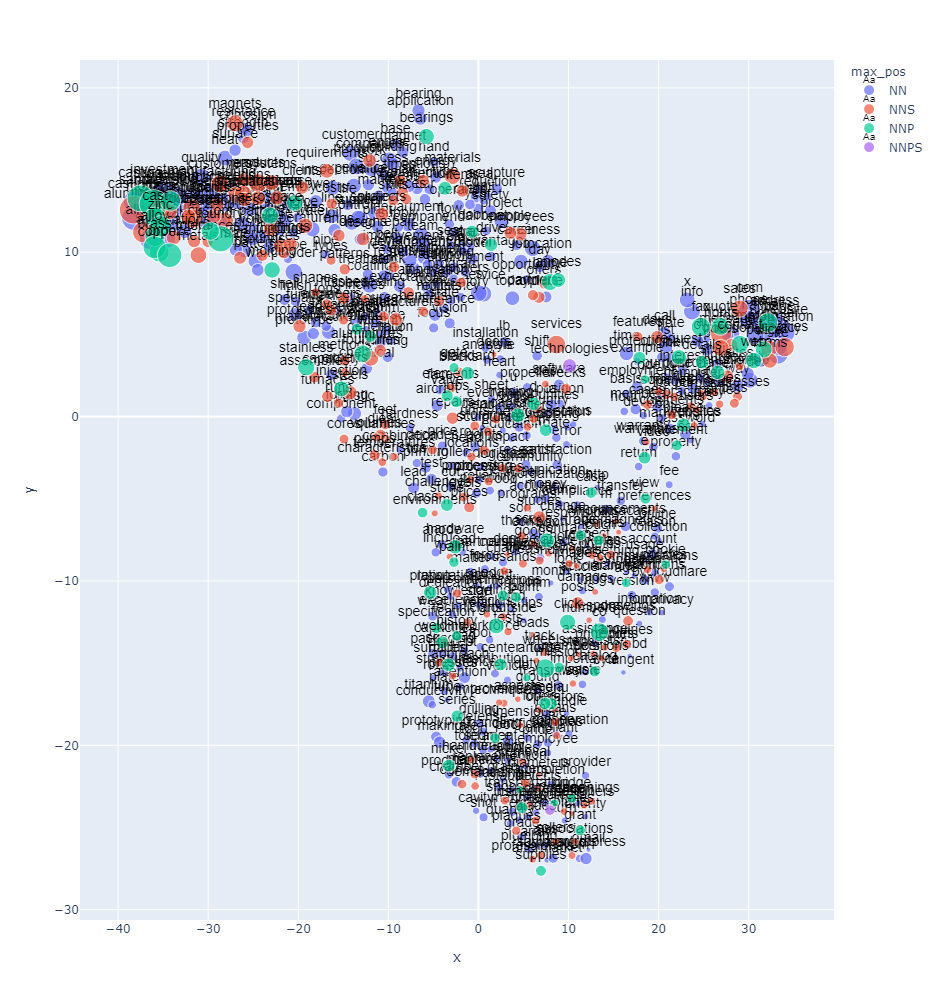

In [34]:
px.scatter(coords_2.reset_index(), 'x', 'y', 
           text='term_str', 
           color='max_pos', 
           hover_name='term_str',          
           size='mean_tfidf',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

<Figure size 432x288 with 0 Axes>

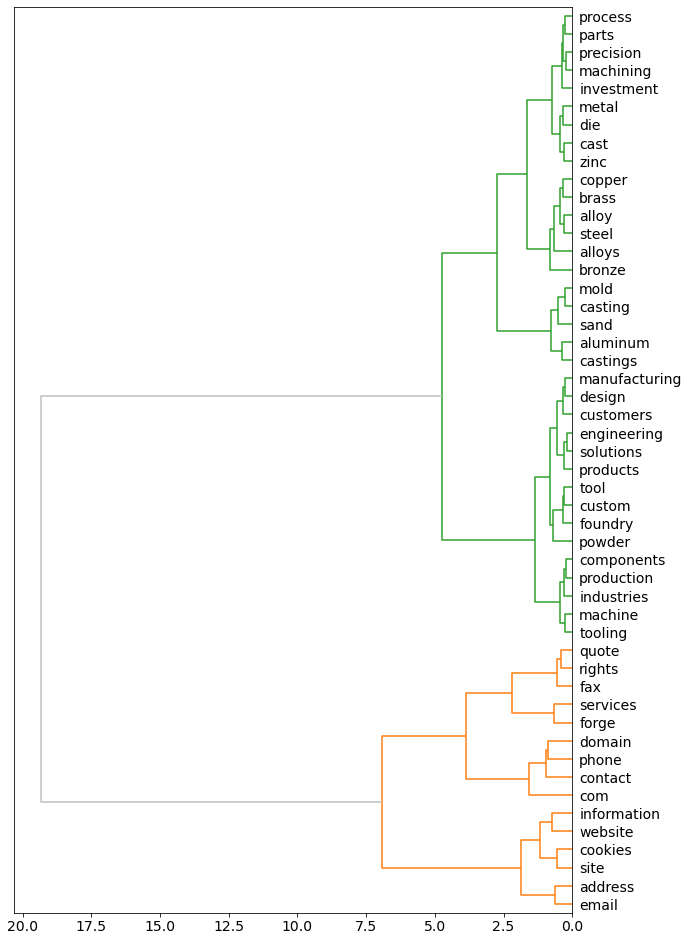

In [35]:
plot_terms_tree(coords_2, color_thresh=9, terms_n=50)

In [36]:
complete_analogy(model_2, 'products', 'product', 'castings', 3)

term       sim
0  metal  0.991908
1   mold  0.991529
2    die  0.991456

In [37]:
complete_analogy(model_2, 'metal', 'steel', 'alloy', 3)

term       sim
0  copper  0.987299
1   brass  0.981125
2  bronze  0.976650

In [38]:
complete_analogy(model_2, 'industry', 'industries', 'casting', 3)

term       sim
0      sand  0.996029
1  castings  0.993866
2      mold  0.992757

In [39]:
complete_analogy(model_2, 'site', 'com', 'customer', 3)

term       sim
0       company  0.899851
1  expectations  0.893919
2       product  0.890308

In [40]:
get_most_similar(model_2, 'quality')

term       sim
0      customers  0.993651
1       industry  0.986883
2  manufacturing  0.986387
3     production  0.984591
4         design  0.982835
5      processes  0.978997
6      equipment  0.978619
7     industries  0.978338
8       facility  0.977245
9    engineering  0.976371

In [41]:
get_most_similar(model_2, 'magnet')

term       sim
0    combination  0.997586
1   temperatures  0.996947
2      treatment  0.996659
3         vacuum  0.996483
4           wire  0.996109
5         source  0.996060
6  specification  0.996020
7           food  0.995993
8            air  0.995938
9         series  0.995920

In [42]:
get_most_similar(model_2, 'castings')

term       sim
0     casting  0.996673
1    aluminum  0.995989
2        sand  0.994531
3        mold  0.993880
4       metal  0.992499
5         die  0.991087
6        cast  0.985777
7  investment  0.983996
8       parts  0.982804
9     process  0.981004

In [43]:
get_most_similar(model_2, 'privacy')

term       sim
0       policy  0.996070
1          use  0.992657
2         site  0.991340
3        sites  0.990790
4          web  0.990051
5         data  0.989126
6  information  0.987272
7       access  0.986545
8      website  0.986266
9      cookies  0.985934

In [44]:
get_most_similar(model_2, 'business')

term       sim
0     employees  0.989935
1  satisfaction  0.988250
2           day  0.987667
3        career  0.985475
4           job  0.984921
5    deliveries  0.984742
6       service  0.983987
7      location  0.983208
8        people  0.983096
9        orders  0.983096

## Model 3

In [45]:
# word2vec parameters
w2v_params = dict(
    window = 5,
    vector_size = 50,
    min_count = 50,
    workers = 4
)

In [46]:
model_3 = word2vec.Word2Vec(DOCS, **w2v_params)

In [47]:
coords_3  = pd.DataFrame(
    dict(
        vector = [model_3.wv.get_vector(w) for w in model_3.wv.index_to_key], 
        term_str = model_3.wv.index_to_key
    )).set_index('term_str')

In [48]:
tsne_engine_3 = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_model_3 = tsne_engine_3.fit_transform(coords_1.vector.to_list())

In [49]:
coords_3['x'] = tsne_model_3[:,0]
coords_3['y'] = tsne_model_3[:,1]

In [50]:
if coords_3.shape[1] == 3:
    coords_3 = coords_3.merge(VOCAB.reset_index(), on='term_str')
    coords_3 = coords_3.set_index('term_str')

In [51]:
coords_3

vector          x  \
term_str                                                                    
quality      [-0.0118884, -0.54115903, -0.77935743, 0.17398... -12.180115   
products     [-0.0060704974, -0.38323855, -0.59296185, 0.02...  -7.790994   
castings     [-0.26531598, -0.46653682, -1.3581587, 0.52410... -14.679938   
customers    [0.022049014, -0.51232976, -0.6725024, 0.09758... -10.966983   
parts        [-0.16488466, -0.43716002, -1.150309, 0.360003... -13.927756   
...                                                        ...        ...   
program      [0.039175253, -0.30445743, -0.4222574, -0.0439...   5.472015   
protection   [0.1294601, -0.16175264, -0.14778851, -0.15387...  11.168120   
software     [0.08271895, -0.22862323, -0.2536481, -0.10189...   8.935071   
file         [0.18733779, -0.103439406, -0.054664392, -0.22...  12.452018   
maintenance  [0.014215466, -0.2965757, -0.45963642, -0.0512...   3.643089   

                     y  index     n         p          i  n_chars max_pos  \
term_str                                                                    
quality       6.720740      0  1369  0.009497   6.718315        7      NN   
products      3.311322      2  1199  0.008318   6.909605        8     NNS   
castings     11.967529      1  1228  0.008519   6.875126        8     NNS   
customers     5.550053     13   678  0.004703   7.732080        9     NNS   
parts        10.759926     10   743  0.005154   7.600003        5     NNS   
...                ...    ...   ...       ...        ...      ...     ...   
program      -3.929123    399    63  0.000437  11.159941        7      NN   
protection   -8.229728    169   128  0.000888  10.137221       10     NNP   
software     -6.810633    442    59  0.000409  11.254578        8      NN   
file        -10.172930    504    52  0.000361  11.436782        4      NN   
maintenance  -3.075948    307    81  0.000562  10.797371       11      NN   

             n_pos                       cat_pos      dfidf  mean_tfidf  
term_str                                                                 
quality          3          {'NNS', 'NNP', 'NN'}  22.920115    0.020423  
products         4  {'NNS', 'NNP', 'NN', 'NNPS'}  33.358238    0.024701  
castings         3        {'NNS', 'NNP', 'NNPS'}  44.741763    0.056828  
customers        3        {'NNS', 'NNP', 'NNPS'}  38.840662    0.022331  
parts            3        {'NNS', 'NNP', 'NNPS'}  43.013495    0.030131  
...            ...                           ...        ...         ...  
program          2                 {'NNP', 'NN'}  31.634041    0.006879  
protection       2                 {'NNP', 'NN'}  36.681417    0.012354  
software         2                 {'NNP', 'NN'}  34.098831    0.009113  
file             2                 {'NNP', 'NN'}  29.426974    0.006192  
maintenance      2                 {'NNP', 'NN'}  35.002451    0.010582  

[290 rows x 13 columns]

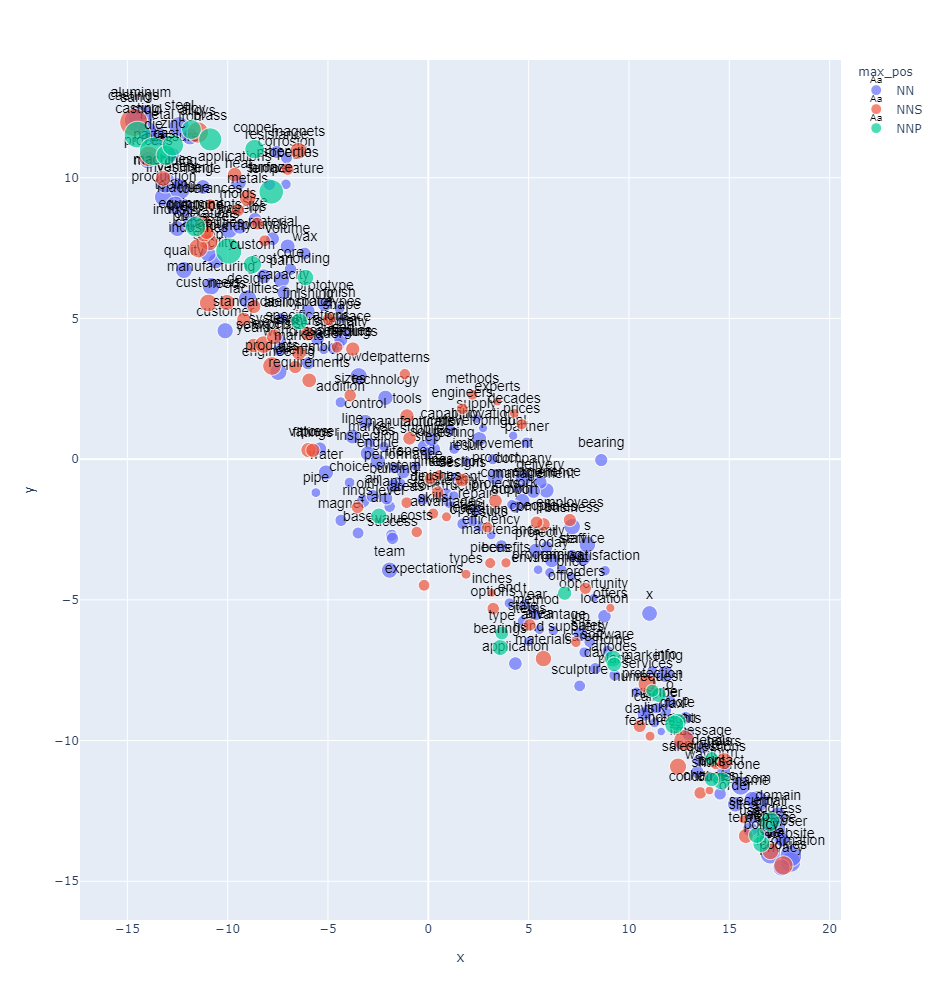

In [52]:
px.scatter(coords_3.reset_index(), 'x', 'y', 
           text='term_str', 
           color='max_pos', 
           hover_name='term_str',          
           size='mean_tfidf',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

<Figure size 432x288 with 0 Axes>

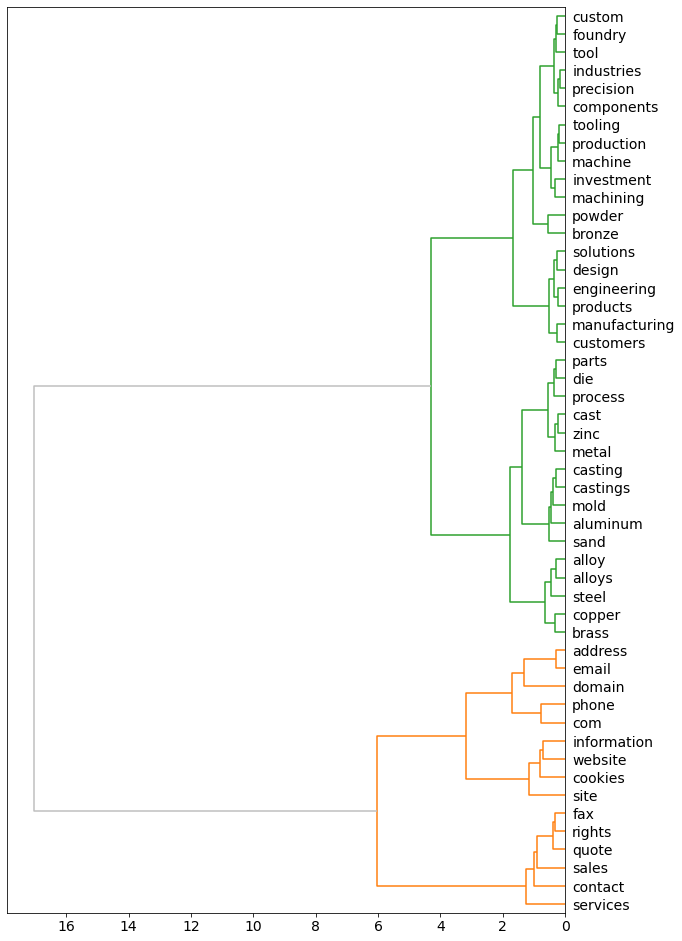

In [53]:
plot_terms_tree(coords_3, color_thresh=9, terms_n=50)

In [54]:
complete_analogy(model_3, 'products', 'product', 'castings', 3)

term       sim
0  investment  0.991610
1       molds  0.987193
2   machining  0.985266

In [55]:
complete_analogy(model_3, 'metal', 'steel', 'alloy', 3)

term       sim
0  alloys  0.989176
1   brass  0.984929
2  copper  0.980552

In [56]:
complete_analogy(model_3, 'industry', 'industries', 'casting', 3)

term       sim
0      mold  0.994790
1     metal  0.992815
2  castings  0.991611

In [57]:
complete_analogy(model_3, 'site', 'com', 'customer', 3)

term       sim
0       company  0.917879
1  expectations  0.910450
2          team  0.906190

In [58]:
get_most_similar(model_3, 'quality')

term       sim
0  manufacturing  0.992745
1      customers  0.989901
2      standards  0.985465
3       facility  0.983964
4       industry  0.982857
5          needs  0.979481
6           shop  0.978455
7     industries  0.976558
8      solutions  0.976345
9      equipment  0.975580

In [59]:
get_most_similar(model_3, 'magnet')

term       sim
0       speed  0.992522
1      choice  0.992155
2         oil  0.992029
3  advantages  0.990791
4         air  0.990060
5       costs  0.989106
6       rings  0.988857
7    finishes  0.988560
8     methods  0.988135
9         gas  0.988057

In [60]:
get_most_similar(model_3, 'castings')

term       sim
0   casting  0.995618
1  aluminum  0.995100
2     metal  0.994109
3       die  0.993567
4      mold  0.991581
5      zinc  0.990636
6      sand  0.990535
7     parts  0.990348
8      cast  0.989140
9   process  0.985765

In [61]:
get_most_similar(model_3, 'privacy')

term       sim
0        sites  0.998151
1       policy  0.996895
2         site  0.995741
3          use  0.995021
4      cookies  0.991193
5          web  0.990950
6      content  0.988724
7         data  0.988579
8  information  0.986949
9     security  0.986564

In [62]:
get_most_similar(model_3, 'business')

term       sim
0     employees  0.990742
1  satisfaction  0.989301
2       service  0.988718
3           day  0.985300
4             s  0.982353
5           job  0.982288
6   opportunity  0.981500
7    management  0.981157
8        people  0.981117
9        career  0.980443